<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/final_model/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [ ]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [ ]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [ ]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [ ]:
del df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
del X, Y
gc.collect()

66

In [ ]:
sm = KMeansSMOTE()
X_t, y_t = sm.fit_resample(X_train, y_train)

In [ ]:
gc.collect()

44

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'FalseNegatives', 'FalsePositives', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives'])

In [ ]:
model.fit(X_t, y_t, epochs=10)

Epoch 1/10
17004/17004 [==============================] - 55s 3ms/step - loss: 0.1724 - accuracy: 0.9280 - auc: 0.9821 - false_negatives: 18967.0000 - false_positives: 20229.0000 - precision: 0.9260 - recall: 0.9303 - true_negatives: 251819.0000 - true_positives: 253082.0000
Epoch 2/10
17004/17004 [==============================] - 55s 3ms/step - loss: 0.1626 - accuracy: 0.9310 - auc: 0.9837 - false_negatives: 17752.0000 - false_positives: 19772.0000 - precision: 0.9279 - recall: 0.9347 - true_negatives: 252276.0000 - true_positives: 254297.0000
Epoch 3/10
17004/17004 [==============================] - 55s 3ms/step - loss: 0.1600 - accuracy: 0.9320 - auc: 0.9842 - false_negatives: 17852.0000 - false_positives: 19121.0000 - precision: 0.9300 - recall: 0.9344 - true_negatives: 252927.0000 - true_positives: 254197.0000
Epoch 4/10
17004/17004 [==============================] - 55s 3ms/step - loss: 0.1588 - accuracy: 0.9326 - auc: 0.9845 - false_negatives: 18049.0000 - false_positives: 1864

In [ ]:
test_loss, test_acc, *is_anything_else_being_returned = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)
print('\n Other Metrics ', is_anything_else_being_returned)


2869/2869 - 6s - loss: 0.2326 - accuracy: 0.9009 - auc: 0.9582 - false_negatives: 4320.0000 - false_positives: 4775.0000 - precision: 0.8027 - recall: 0.8181 - true_negatives: 63262.0000 - true_positives: 19426.0000 - 6s/epoch - 2ms/step

Test accuracy: 0.900907576084137

Test loss: 0.23261268436908722

 Other Metrics  [0.9582293033599854, 4320.0, 4775.0, 0.8026940822601318, 0.818074643611908, 63262.0, 19426.0]


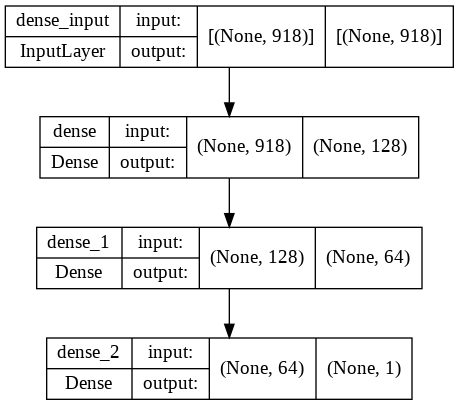

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="/tmp/model.png", show_shapes=True)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [ ]:
y_pred

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(63262, 4775, 4320, 19426)

In [ ]:
tn, fp, fn, tp

(63262, 4775, 4320, 19426)

In [ ]:
f1_score(y_test, y_pred)

0.8103113854881431

In [ ]:
roc_auc_score(y_test, y_pred)

0.8739461111709421

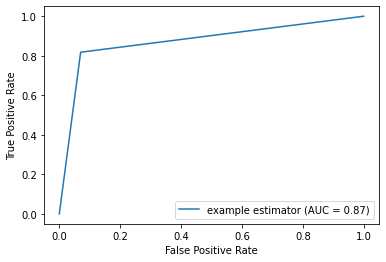

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9361    0.9298    0.9329     68037
           1     0.8027    0.8181    0.8103     23746

    accuracy                         0.9009     91783
   macro avg     0.8694    0.8739    0.8716     91783
weighted avg     0.9016    0.9009    0.9012     91783



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               117632    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 125,953
Trainable params: 125,953
Non-trainable params: 0
_________________________________________________________________
